In [80]:
import os
import requests
from dotenv import load_dotenv
import pandas as pd
import pycountry
import pypopulation
from geojson import FeatureCollection, dump
from helpers import normalize_country_names
import numpy as np
import xlrd
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon, box
from shapely.ops import unary_union
from shapely import union_all

## Geocoding
Assigning countries coordinates

In [81]:
load_dotenv()
TOKEN=os.getenv("MAPBOX_TOKEN")
df = pd.read_csv("../output/processed/flows.csv") # ../output/processed/
origins = list(df.origin.unique())
destinations = list(df.destination.unique())


In [82]:
df

,Unnamed: 0,origin,destination,year,UN1,UN3,UN4.1,UN4.2,UN4.3,UN5.1,UN5.2,UN6.1,UN6.2,UN8,UN9,unspecified,multiple
0,0,ad,es,2002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7777.400,0.00
1,1,ad,es,2003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,486.800,0.00
2,2,ad,es,2004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,425.980,0.00
3,3,ad,es,2005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,621.950,0.00
4,4,ad,es,2006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1044.092,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8103,8103,za,se,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,0.000,0.00
8104,8104,za,sg,2010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,720.0,0.000,0.00
8105,8105,za,tr,2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,21.24
8106,8106,zm,fi,2002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,235.000,0.00


In [83]:
in_first = set(origins)
in_second = set(destinations)
in_second_but_not_in_first = in_second - in_first
countries = origins + list(in_second_but_not_in_first)

In [84]:
df = pd.DataFrame({"code":countries})
df

,code
0,ad
1,ae
2,af
3,al
4,am
...,...
150,hk
151,ss
152,sl
153,tj


In [85]:
headers = {'Accept': 'application/json'}
lst = []
for i in countries:
    obj = {}
    obj["type"]="Feature"
    obj["properties"]={"name": pycountry.countries.get(alpha_2=i).name}
    pop = pypopulation.get_population_a2(i)
    url = f"https://api.mapbox.com/geocoding/v5/mapbox.places/{pycountry.countries.get(alpha_2=i).name}.json?&types=country&access_token={TOKEN}"
    r = requests.get(url)
    jason = r.json()
    obj["properties"]["code"] = i.lower()
    coords = jason["features"][0]["center"]
    bbox = jason["features"][0]["bbox"]
    obj["geometry"] = {"type":"Point", "coordinates": coords}
    lst.append(obj)
    df.loc[df["code"] == i, "lat"] = coords[1]
    df.loc[df["code"] == i, "lon"] = coords[0]
    df.loc[df["code"] == i, "name"] = obj["properties"]["name"]
    df.loc[df["code"] == i, "population"] = pop
    df.loc[df["code"] == i, "bbox"] = str(bbox)
    if i in destinations and not i in origins:
        df.loc[df["code"] == i, "destination_only"] = True
    else:
        df.loc[df["code"] == i, "destination_only"] = False

In [86]:
with open('../output/processed/countries.geojson', 'w') as f:
    dump(FeatureCollection(lst), f)

In [87]:
df['population'] = df['population'].fillna(0).astype(int)

In [88]:
# filling one country manually
df.loc[df[df["name"]=="Saint Barthélemy"].index, 'population'] = 10457
df = df.astype({'population':'str'})

## Clustering


In [89]:


# https://unstats.un.org/unsd/methodology/m49/overview/
regions = pd.read_excel("regions.xls")
# https://hdr.undp.org/data-center/documentation-and-downloads
# HDI 2021
hdi = pd.read_excel("HDI.xls")
hdi.rename(columns={"Human Development Index (HDI) ": "HDI"}, inplace=True)
hdi["code"] = hdi["Country"].apply(normalize_country_names)
hdi

,HDI rank,Country,HDI,Life expectancy at birth,Expected years of schooling,Mean years of schooling,Gross national income (GNI) per capita,GNI per capita rank minus HDI rank,code
0,1.0,Switzerland,0.962,83.9872,16.500299,13.85966,66933.00454,5,ch
1,2.0,Norway,0.961,83.2339,18.1852,13.00363,64660.10622,6,no
2,3.0,Iceland,0.959,82.6782,19.163059,13.76717,55782.04981,11,is
3,4.0,"Hong Kong, China (SAR)",0.952,85.4734,17.27817,12.22621,62606.8454,6,hk
4,5.0,Australia,0.951,84.5265,21.05459,12.72682,49238.43335,18,au
...,...,...,...,...,...,...,...,...,...
190,191.0,South Sudan,0.385,54.9752,5.54251,5.72614,767.787,-1,ss
191,NaN,Korea (Democratic People's Rep. of),..,73.2845,10.78317,..,..,..,kp
192,NaN,Monaco,..,85.9463,..,..,..,..,mc
193,NaN,Nauru,..,63.6170,11.69042,..,17729.74084,..,nr


In [90]:
# Region
def func(x, col):
    iso3 = pycountry.countries.get(alpha_2=x).alpha_3
    result = regions[regions["ISO-alpha3 Code"] == iso3][col].values[0]
    return result

df["region_code"] = df.apply(lambda x: func(x["code"], "Region Code"), axis=1)
df["region_name"] = df.apply(lambda x: func(x["code"], "Region Name"), axis=1)

# Subregion
df["sub_region_code"] = df.apply(lambda x: func(x["code"], "Sub-region Code"), axis=1)
df["sub_region_name"] = df.apply(lambda x: func(x["code"], "Sub-region Name"), axis=1)

In [91]:
# HDI
def func(x):
    # american samoa doesn't exist in classification
    if x == "as":
        return 999
    # gibraltar doesn't exist in classification
    if x == "gi":
        return 999
    # Saint-Barthélemy doesn't exist in classification
    if x =="bl":
        return 999
    # Unclassified country mentioned in report
    if hdi[hdi["code"] == x]["HDI"].values[0] == "..":
        return 999
    result = float(hdi[hdi["code"] == x]["HDI"].values[0])
    return result

df["HDI"] = df.apply(lambda x: func(x["code"]), axis=1)

In [92]:
# 2021 based on https://hdr.undp.org/system/files/documents/global-report-document/hdr2021-22pdf_1.pdf  S.268
hdi_classes = {"very_high": [0.8,1], "high": [0.700,0.799], "medium": [0.55,0.699], "low": [0,0.549]}
def func(x):
    if x == 999:
        return "unclassified"
    if x <= hdi_classes["low"][1]:
        return "low"
    if hdi_classes["medium"][0] <= x <= hdi_classes["medium"][1]:
        return "medium"
    if hdi_classes["high"][0] <= x <= hdi_classes["high"][1]:
        return "high"
    if hdi_classes["very_high"][0] <= x:
        return "very_high"
    print(x)

df["hdi_code"] = df.apply(lambda x: func(x["HDI"]), axis=1)

In [93]:
df["hdi_name"] = df.apply(lambda x: x["hdi_code"].replace("_", " ").title(), axis=1)

In [104]:
regions_ = {"Europe": [50.954692, 14.710857],"Asia": [35.459903, 79.899961],"Americas": [9.816245, -83.985292 ], "Oceania": [-24.155138, 144.572012 ],"Africa": [3.018519, 23.495710 ]}

sub_regions = {"Southern Europe": [43.078547129148966, 11.322942551609177],"Western Asia": [29.55756090313516, 42.44329454726712],"Southern Asia": [29.706997, 70.905342], "Latin America and the Caribbean": [-3.217065, -64.771275 ],"Western Europe": [ 49.269893, 5.539730 ], "Australia and New Zealand": [-35.069432, 154.953651],"Eastern Europe": [61.225572, 58.129048 ],"Sub-Saharan Africa": [ -6.846378, 23.645431 ],"South-eastern Asia": [3.7475381775653744, 116.05633077644896],"Northern America": [46.273467, -102.378211 ],"Eastern Asia": [40.612380, 108.240696 ],"Northern Europe": [60.439321, 8.110377 ],"Northern Africa": [23.728513, 13.013446 ],"Central Asia": [45.52807689959419, 66.85787353846288],"Melanesia": [-10.293643, 150.675081],"Polynesia": [-12.974755091871536, -166.8581651283315]}

hdi_coords = {"very_high": [50.25975902640112, -32.297410847209406], "high": [-7.9309896818122585, -50.227096820785555], "medium": [21.57354521069637, 79.06000344355911], "low": [3.2917489651292065, 25.44672584500442], "unclassified": [0,0]}


In [95]:
# def func(x):
#     bbox = (eval(x)[1],eval(x)[0],eval(x)[3],eval(x)[2])
#     return box(*bbox, ccw=True)
# df["polygon"] = df.apply(lambda x: func(x["bbox"]), axis=1)

In [96]:
# def centroids(typ):
#     obj = {}
#     for i in list(df[f"{typ}_name"].unique()):
#         polygons = list(df[df[f"{typ}_name"] == i]["polygon"])
#         u = union_all(polygons)
#         obj[i] = u.centroid
#     df[f"{typ}_lat"] = df.apply(lambda x: obj[x[f"{typ}_name"]].xy[0][0], axis=1)
#     df[f"{typ}_lon"] = df.apply(lambda x: obj[x[f"{typ}_name"]].xy[1][0], axis=1)

In [97]:
# gpd.GeoSeries(list(df[f"polygon"].unique())).plot()

In [98]:
# def centroids(typ):
#     obj = {}
#     for i in list(df[f"{typ}_name"].unique()):
#         lats = df[df[f"{typ}_name"] == i]["lat"]
#         lons = df[df[f"{typ}_name"] == i]["lon"]
#         lat = sum(lats)/len(lats)
#         lon = sum(lons)/len(lons)
#         obj[i] = [lat,lon]
#
#     df[f"{typ}_lat"] = df.apply(lambda x: obj[x[f"{typ}_name"]][0], axis=1)
#     df[f"{typ}_lon"] = df.apply(lambda x: obj[x[f"{typ}_name"]][1], axis=1)

In [99]:
# def centroids(typ):
#     obj = {}
#     for i in list(df[f"{typ}_name"].unique()):
#         polygons = list(df[df[f"{typ}_name"] == i]["polygon"])
#         u = union_all(polygons)
#         obj[i] = u.centroid
#     df[f"{typ}_lat"] = df.apply(lambda x: obj[x[f"{typ}_name"]].xy[0][0], axis=1)
#     df[f"{typ}_lon"] = df.apply(lambda x: obj[x[f"{typ}_name"]].xy[1][0], axis=1)
#
# df["region2_name"] = df["region_name"]
# df.loc[df["name"].isin(["Samoa","American Samoa"]), "region2_name"] = 0

In [111]:

df["region_lat"] = df.apply(lambda x: regions_[x["region_name"]][0], axis=1)
df["region_lon"] = df.apply(lambda x: regions_[x["region_name"]][1], axis=1)
df["sub_region_lat"] = df.apply(lambda x: sub_regions[x["sub_region_name"]][0], axis=1)
df["sub_region_lon"] = df.apply(lambda x: sub_regions[x["sub_region_name"]][1], axis=1)
df["hdi_lat"] = df.apply(lambda x: hdi_coords[x["hdi_code"]][0], axis=1)
df["hdi_lon"] = df.apply(lambda x: hdi_coords[x["hdi_code"]][1], axis=1)

In [112]:
# df.drop('region2_name', axis = 1, inplace=True)
# df.drop('polygon', axis = 1, inplace=True)
# df.drop('bbox', axis = 1, inplace=True)
# df.rename(columns={'region2_lat': "region_lat", "region2_lon": "region_lon" }, inplace=True)
df

,code,name,lat,lon,region_code,region_name,region_lat,region_lon,sub_region_code,sub_region_name,sub_region_lat,sub_region_lon,hdi_code,hdi_name,population,destination_only,hdi_lat,hdi_lon
0,ad,Andorra,42.548654,1.576766,150.0,Europe,50.954692,14.710857,39.0,Southern Europe,43.078547,11.322943,very_high,Very High,77142,False,50.259759,-32.297411
1,ae,United Arab Emirates,23.852060,54.256172,142.0,Asia,35.459903,79.899961,145.0,Western Asia,29.557561,42.443295,very_high,Very High,9770529,False,50.259759,-32.297411
2,af,Afghanistan,33.838806,66.026471,142.0,Asia,35.459903,79.899961,34.0,Southern Asia,29.706997,70.905342,low,Low,38041754,False,3.291749,25.446726
3,al,Albania,40.641090,20.156691,150.0,Europe,50.954692,14.710857,39.0,Southern Europe,43.078547,11.322943,high,High,2854191,False,-7.930990,-50.227097
4,am,Armenia,40.605656,44.660395,142.0,Asia,35.459903,79.899961,145.0,Western Asia,29.557561,42.443295,high,High,2957731,False,-7.930990,-50.227097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,hk,Hong Kong,22.279356,114.162550,142.0,Asia,35.459903,79.899961,30.0,Eastern Asia,40.612380,108.240696,very_high,Very High,7507400,True,50.259759,-32.297411
151,ss,South Sudan,7.265386,30.054890,2.0,Africa,3.018519,23.495710,202.0,Sub-Saharan Africa,-6.846378,23.645431,low,Low,11062113,True,3.291749,25.446726
152,sl,Sierra Leone,8.560284,-11.791922,2.0,Africa,3.018519,23.495710,202.0,Sub-Saharan Africa,-6.846378,23.645431,low,Low,7813215,True,3.291749,25.446726
153,tj,Tajikistan,38.838508,71.042004,142.0,Asia,35.459903,79.899961,143.0,Central Asia,45.528077,66.857874,medium,Medium,9321018,True,21.573545,79.060003


In [ ]:
# df.loc[df["name"].isin(["Samoa","American Samoa"]), "region_lat"] = df.loc[df["name"] == "Australia"]["region_lat"].values[0]
# df.loc[df["name"].isin(["Samoa","American Samoa"]), "region_lon"] = df.loc[df["name"] == "Australia"]["region_lon"].values[0]

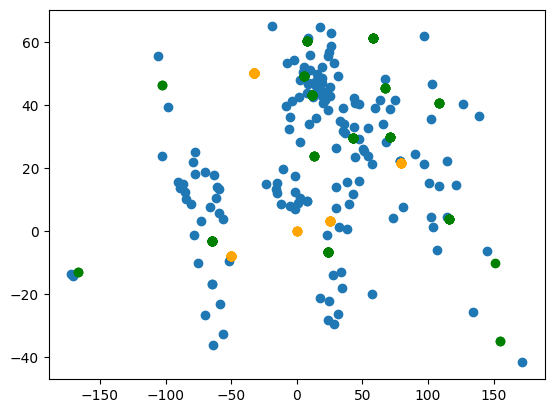

In [106]:
plt.scatter(df["lon"], df["lat"])
# plt.scatter(df["region_lon"], df["region_lat"], c="red")
plt.scatter(df["sub_region_lon"], df["sub_region_lat"], c="green")
# plt.scatter(df["hdi_lon"], df["hdi_lat"], c="orange")
plt.show()

In [113]:
df = df[["code","name","lat","lon","region_code","region_name","region_lat","region_lon","sub_region_code","sub_region_name", "sub_region_lat", "sub_region_lon","hdi_code","hdi_name","hdi_lat","hdi_lon","population","destination_only",]]
df

,code,name,lat,lon,region_code,region_name,region_lat,region_lon,sub_region_code,sub_region_name,sub_region_lat,sub_region_lon,hdi_code,hdi_name,hdi_lat,hdi_lon,population,destination_only
0,ad,Andorra,42.548654,1.576766,150.0,Europe,50.954692,14.710857,39.0,Southern Europe,43.078547,11.322943,very_high,Very High,50.259759,-32.297411,77142,False
1,ae,United Arab Emirates,23.852060,54.256172,142.0,Asia,35.459903,79.899961,145.0,Western Asia,29.557561,42.443295,very_high,Very High,50.259759,-32.297411,9770529,False
2,af,Afghanistan,33.838806,66.026471,142.0,Asia,35.459903,79.899961,34.0,Southern Asia,29.706997,70.905342,low,Low,3.291749,25.446726,38041754,False
3,al,Albania,40.641090,20.156691,150.0,Europe,50.954692,14.710857,39.0,Southern Europe,43.078547,11.322943,high,High,-7.930990,-50.227097,2854191,False
4,am,Armenia,40.605656,44.660395,142.0,Asia,35.459903,79.899961,145.0,Western Asia,29.557561,42.443295,high,High,-7.930990,-50.227097,2957731,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,hk,Hong Kong,22.279356,114.162550,142.0,Asia,35.459903,79.899961,30.0,Eastern Asia,40.612380,108.240696,very_high,Very High,50.259759,-32.297411,7507400,True
151,ss,South Sudan,7.265386,30.054890,2.0,Africa,3.018519,23.495710,202.0,Sub-Saharan Africa,-6.846378,23.645431,low,Low,3.291749,25.446726,11062113,True
152,sl,Sierra Leone,8.560284,-11.791922,2.0,Africa,3.018519,23.495710,202.0,Sub-Saharan Africa,-6.846378,23.645431,low,Low,3.291749,25.446726,7813215,True
153,tj,Tajikistan,38.838508,71.042004,142.0,Asia,35.459903,79.899961,143.0,Central Asia,45.528077,66.857874,medium,Medium,21.573545,79.060003,9321018,True


In [114]:
df.to_csv("../output/processed/countries.csv", index=False)